# Scan MERRA-2 atmospheric properties during one year
----------------------------------------------------------------------------------

- author: Sylvie Dagoret-Campagne
- creation : April 25th 2018
- Update : June 5th 2019
- Update : December 5th 2022


- Kernel **anaconda_py39_auxtel**

Link:

http://disc.sci.gsfc.nasa.gov/datareleases/merra_2_data_release

### purpose:

Scan One year of MERRA-2 predictions of the dataset tavg1_2d_aer_Nx_M2T1NXAER. 
Extract the relevant atmospheric variables.
Build the correcponding time series and dataset in pandas.
Plot the variables. Save the pandas dataset into a file.
Convert the pandas dataset into an astropy fits table and save into a fits file as well.



## 1) python libraries
---------------------------

In [1]:
# Set up matplotlib and use a nicer set of plot parameters
%config InlineBackend.rc = {}
import matplotlib
import matplotlib as mpl
matplotlib.rc_file("templates/matplotlibrc")
import matplotlib.pyplot as plt
%matplotlib inline


Bad key axes.color_cycle in file templates/matplotlibrc, line 215 ('axes.color_cycle    : 348ABD, 7A68A6, A60628, 467821, CF4457, 188487, E24A33')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.2/matplotlibrc.template
or from the matplotlib source distribution

Bad key keymap.all_axes in file templates/matplotlibrc, line 393 ('keymap.all_axes : a                 # enable all axes')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.5.2/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
import datetime

In [3]:
from matplotlib.dates import MonthLocator, WeekdayLocator,DateFormatter
from matplotlib.dates import MONDAY

In [4]:
mondays = WeekdayLocator(MONDAY)
months = MonthLocator(range(1, 13), bymonthday=1, interval=1)
monthsFmt = DateFormatter("%b '%y")

In [5]:
import os
import re
import numpy as np
#from mpl_toolkits.basemap import Basemap
from matplotlib import colors
from matplotlib.backends.backend_pdf import PdfPages
import pandas as pd

In [6]:
from astropy import units as u
from astropy.coordinates import SkyCoord

from astropy.table import Table

In [7]:
import h5py

In [8]:
import libGMAOMERRA2Data as merra2  # My own library

In [9]:
############################################################################
def ensure_dir(f):
    d = os.path.dirname(f)
    if not os.path.exists(f):
        os.makedirs(f)
#########################################################################

## 2)  Configuration
-------------------------

In [10]:
YEARNUM="2022"

In [11]:
# SELECT OBSERVATORY
OBS_NAME='lsst'

In [12]:
# where are the HDF files
#HDFEOS_ZOO_DIR="/Volumes/DAGORETBACK/MERRA-2/inst1_2d_asm_Nx_M2I1NXASM/2016"
#HDFEOS_ZOO_DIR="/Volumes/LaCie2/DATA/MERRA-2/tavg1_2d_aer_Nx_M2T1NXAER"
#HDFEOS_ZOO_DIR="/sps/lsst/data/AtmosphericCalibration/MERRA-2/May-Jun-2017/subset_M2T1NXRAD_V5.12.4_20180424_203634"

In [13]:
#HDFEOS_ZOO_DIR="/Users/dagoret/DATA/MERRA-2/M2T1NXRAD_V5.12.4"
#HDFEOS_ZOO_DIR=os.path.join("/Users/dagoret/DATA/MERRA-2/M2T1NXRAD_V5.12.4",YEARNUM)
HDFEOS_ZOO_DIR=os.path.join("/sps/lsst/groups/auxtel/MERRA2/data/tavg1_2d_rad_Nx_M2T1NXRAD",YEARNUM)

In [14]:
path=HDFEOS_ZOO_DIR


### Here I describe the content of the input files

In [15]:
DATA_TAG=['TAUHGH','TAULOW','TAUMID','TAUTOT']

In [16]:
DATA_TITLE=['In cloud optical thickness of high clouds',
            'In cloud optical thickness of low clouds',
            'In cloud optical thickness of middle clouds',
            'In cloud optical thickness of all clouds'
           ]

In [17]:
NB_DATAFIELDS=len(DATA_TAG)

### List of output files

In [18]:
# The selected data field
DATA_NAME =  'tavg1_2d_rad_Nx_M2T1NXRAD'   # 

In [19]:
pandas_filename='MERRA2_'+YEARNUM+'_'+DATA_NAME+'_'+OBS_NAME+'_'+'AllYear'+'.csv'

In [20]:
fits_filename='MERRA2_'+YEARNUM+'_'+DATA_NAME+'_'+OBS_NAME+'_'+'AllYear' +'.fits'

In [21]:
# 6 output files for figures
figfile_rad_tauhigh='GMAO_MERRA2_'+YEARNUM+'_'+DATA_NAME+'_'+OBS_NAME+'_'+'AllYear'+'_'+'AllYear'+'_rad_tauh'+'.jpg'
figfile_rad_taulow='GMAO_MERRA2_'+YEARNUM+'_'+DATA_NAME+'_'+OBS_NAME+'_'+'AllYear'+'_'+'AllYear'+'_rad_taul'+'.jpg'
figfile_rad_taumid='GMAO_MERRA2_'+YEARNUM+'_'+DATA_NAME+'_'+OBS_NAME+'_'+'AllYear'+'_'+'AllYear'+'_rad_taum'+'.jpg'
figfile_rad_tautot='GMAO_MERRA2_'+YEARNUM+'_'+DATA_NAME+'_'+OBS_NAME+'_'+'AllYear'+'_'+'AllYear'+'_rad_taut'+'.jpg'

### Select where in the world

In [22]:
# Select observatory
loc=merra2.observatory_location(OBS_NAME)

In [23]:
loc

(-70.7366833333333, -30.240741666666672, 2749.999999999238)

### 2.2) Getting the list of the files
------------------------------

In [24]:
nc4_files = [f for f in os.listdir(path) if f.endswith('.nc4')]  

In [25]:
nc4_files[:5]

['MERRA2_400.tavg1_2d_rad_Nx.20221012.nc4',
 'MERRA2_400.tavg1_2d_rad_Nx.20220925.nc4',
 'MERRA2_400.tavg1_2d_rad_Nx.20220612.nc4',
 'MERRA2_400.tavg1_2d_rad_Nx.20220215.nc4',
 'MERRA2_400.tavg1_2d_rad_Nx.20221023.nc4']

### 2.3) Select files of a given month

In [26]:
keysel_filename='^MERRA2_400.tavg1_2d_rad_Nx.'+YEARNUM+'.*'

In [27]:
print('Selection key' ,keysel_filename)

Selection key ^MERRA2_400.tavg1_2d_rad_Nx.2022.*


In [28]:
nc4_files2 = []
for file in nc4_files:
    if re.findall(keysel_filename,file):
        nc4_files2.append(file)

nc4_files2=np.array(nc4_files2)

In [29]:
nc4_files2

array(['MERRA2_400.tavg1_2d_rad_Nx.20221012.nc4',
       'MERRA2_400.tavg1_2d_rad_Nx.20220925.nc4',
       'MERRA2_400.tavg1_2d_rad_Nx.20220612.nc4',
       'MERRA2_400.tavg1_2d_rad_Nx.20220215.nc4',
       'MERRA2_400.tavg1_2d_rad_Nx.20221023.nc4',
       'MERRA2_400.tavg1_2d_rad_Nx.20220711.nc4',
       'MERRA2_400.tavg1_2d_rad_Nx.20220630.nc4',
       'MERRA2_400.tavg1_2d_rad_Nx.20220818.nc4',
       'MERRA2_400.tavg1_2d_rad_Nx.20220211.nc4',
       'MERRA2_400.tavg1_2d_rad_Nx.20220804.nc4',
       'MERRA2_400.tavg1_2d_rad_Nx.20220902.nc4',
       'MERRA2_400.tavg1_2d_rad_Nx.20220615.nc4',
       'MERRA2_400.tavg1_2d_rad_Nx.20220302.nc4',
       'MERRA2_400.tavg1_2d_rad_Nx.20220325.nc4',
       'MERRA2_400.tavg1_2d_rad_Nx.20220324.nc4',
       'MERRA2_400.tavg1_2d_rad_Nx.20220416.nc4',
       'MERRA2_400.tavg1_2d_rad_Nx.20220701.nc4',
       'MERRA2_400.tavg1_2d_rad_Nx.20221024.nc4',
       'MERRA2_400.tavg1_2d_rad_Nx.20220624.nc4',
       'MERRA2_400.tavg1_2d_rad_Nx.20220824.nc4',


### 2.4) Sort files by increasing time

In [30]:
nc4_files=np.sort(nc4_files2)

### 2.5) Build the full filename before reading

In [31]:
NBFILES=len(nc4_files)
full_nc4files=[]

for file in nc4_files:
    fname = os.path.join(path, file)
    full_nc4files.append(fname)  

## 3)  Extract data and write them into pandas dataset and time series
--------------------------------------------------------------------------------------

In [32]:
ts0=[]  # intermediate data series
ts1=[]
ts2=[]
ts3=[]


df_tavg1_2d_rad_Nx=[] # final pandas dataset for all atmospheric quantities

for file in full_nc4files: # loop on data file of each day of the month
    
    #Retrieve 1D parameters longitude, latitude, time
    (m_lat,m_un_lat,m_nm_lat) = merra2.Get1DData(file,'lat') # latitude (array, unit, name)
    m_latitude = m_lat[:]
    (m_lon,m_un_lon,m_nm_lon) = merra2.Get1DData(file,'lon') # longitude(array, unit, name)
    m_longitude = m_lon[:]
    (m_tim,m_un_tim,m_nm_tim)= merra2.Get1DData(file,'time') # time (array, unit, name)
    m_time=m_tim[:]
    
     # with python3 obliged to transform byte string into a string    
    m_un_tim2=m_un_tim.decode("utf-8")  
    
       
    NbDataPerFile=m_time.shape[0] # number of data sample per file
    #start_time = re.findall("^minutes since[ ]([0-9.].+[0-9.].+[0-9.].+)[ ]00:00:00$",m_un_tim) # extract start time
    start_time = re.findall("^minutes since[ ]([0-9.].+[0-9.].+[0-9.].+)",m_un_tim2) # extract start time
    
    #print 'start_time = ', start_time
    time_rng = pd.date_range(start_time[0], periods=NbDataPerFile, freq='H') # one data per hour
    
    print('---------------------------------------------')
    print('NbDataPerFile = ', NbDataPerFile)
    print('start_time = ', start_time)
    print('time_rng   = ', time_rng[:5])
    
    
    m_X,m_Y=np.meshgrid(m_longitude,m_latitude) # build meash-grid in longitude and latitude
    (sel_long, sel_lat)=merra2.GetBinIndex(m_X,m_Y,loc[0],loc[1]) # get bin in longitude and latitude for the site  
    
 
    # loop
    for index in range(NB_DATAFIELDS):
        (m_data,m_unit,m_longname)=merra2.GetGeoRefData(file,DATA_TAG[index]) # 3D array : time x longitude x latitude  
        dt=m_data[:,sel_lat,sel_long]
        if index==0:
            ts0 = pd.Series(dt, index=time_rng)
        elif index==1:
            ts1 = pd.Series(dt, index=time_rng)
        elif index==2:
            ts2 = pd.Series(dt, index=time_rng)
        elif index==3:
            ts3 = pd.Series(dt, index=time_rng)

            
    #clf_timeseries.append(ts)
    # Create the dataframe
    df = pd.DataFrame({DATA_TAG[0]: ts0, 
                       DATA_TAG[1]: ts1,
                       DATA_TAG[2]: ts2,
                       DATA_TAG[3]: ts3 }, index=time_rng)
    df_tavg1_2d_rad_Nx.append(df)  
    

---------------------------------------------
NbDataPerFile =  24
start_time =  ['2022-01-01 00:30:00']
time_rng   =  DatetimeIndex(['2022-01-01 00:30:00', '2022-01-01 01:30:00',
               '2022-01-01 02:30:00', '2022-01-01 03:30:00',
               '2022-01-01 04:30:00'],
              dtype='datetime64[ns]', freq='H')
---------------------------------------------
NbDataPerFile =  24
start_time =  ['2022-01-02 00:30:00']
time_rng   =  DatetimeIndex(['2022-01-02 00:30:00', '2022-01-02 01:30:00',
               '2022-01-02 02:30:00', '2022-01-02 03:30:00',
               '2022-01-02 04:30:00'],
              dtype='datetime64[ns]', freq='H')
---------------------------------------------
NbDataPerFile =  24
start_time =  ['2022-01-03 00:30:00']
time_rng   =  DatetimeIndex(['2022-01-03 00:30:00', '2022-01-03 01:30:00',
               '2022-01-03 02:30:00', '2022-01-03 03:30:00',
               '2022-01-03 04:30:00'],
              dtype='datetime64[ns]', freq='H')
-------------------

### Concatenation

In [33]:
df_tavg1_2d_rad_Nx=pd.concat(df_tavg1_2d_rad_Nx)

In [34]:
df_tavg1_2d_rad_Nx.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7056 entries, 2022-01-01 00:30:00 to 2022-10-31 23:30:00
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TAUHGH  7056 non-null   float32
 1   TAULOW  7056 non-null   float32
 2   TAUMID  7056 non-null   float32
 3   TAUTOT  7056 non-null   float32
dtypes: float32(4)
memory usage: 165.4 KB


## 4) Plot the time dependence of time series and dataset

####  Fill information on years and months from the filenames

In [35]:
def PlotTimeSeries(index,figfile):
    plt.figure(figsize=(20,5))
    df_tavg1_2d_rad_Nx[DATA_TAG[index]].plot(lw=2,color='red')
    plt.xlabel('time')
    plt.ylabel(DATA_TAG[index])
    title= "Hourly {} at {} in {}".format(DATA_TITLE[index],OBS_NAME,YEARNUM)
    plt.title(title,fontsize=15)
    plt.suptitle('NASA GMAO GES (MERRA-2)', y=1.02, fontsize=13)
    plt.grid(True)
    plt.savefig(figfile)

### 4.1) $\tau$-High-clouds

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Helvetica, Bitstream Vera Sans, Lucida Grande, Verdana, Geneva, Lucid, Avant Garde, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Helvetica, Bitstream Vera Sans, Lucida Grande, Verdana, Geneva, Lucid, Avant Garde, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial, Helvetica, Bitstream Vera Sans, Lucida Grande, Verdana, Geneva, Lucid, Avant Garde, sans-serif
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families we

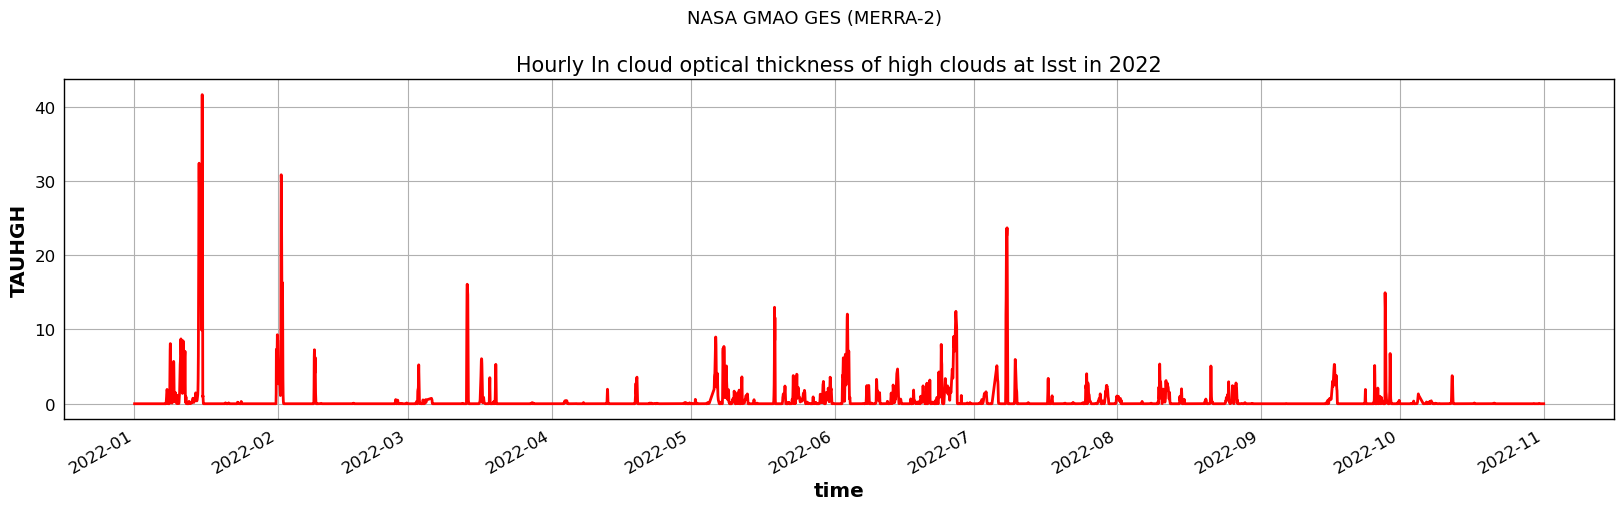

In [36]:
PlotTimeSeries(0,figfile_rad_tauhigh)

###  4.2)  $\tau$-Low-Clouds

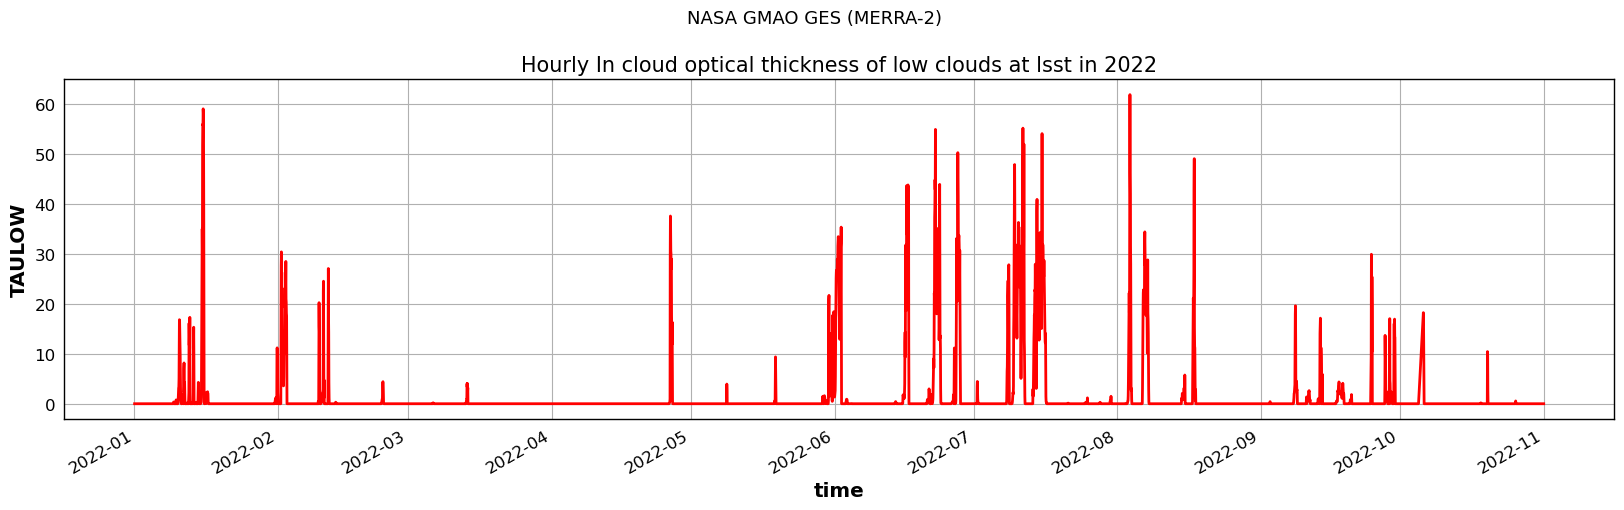

In [37]:
PlotTimeSeries(1,figfile_rad_taulow)

### 4.3) $\tau$-mid-clouds

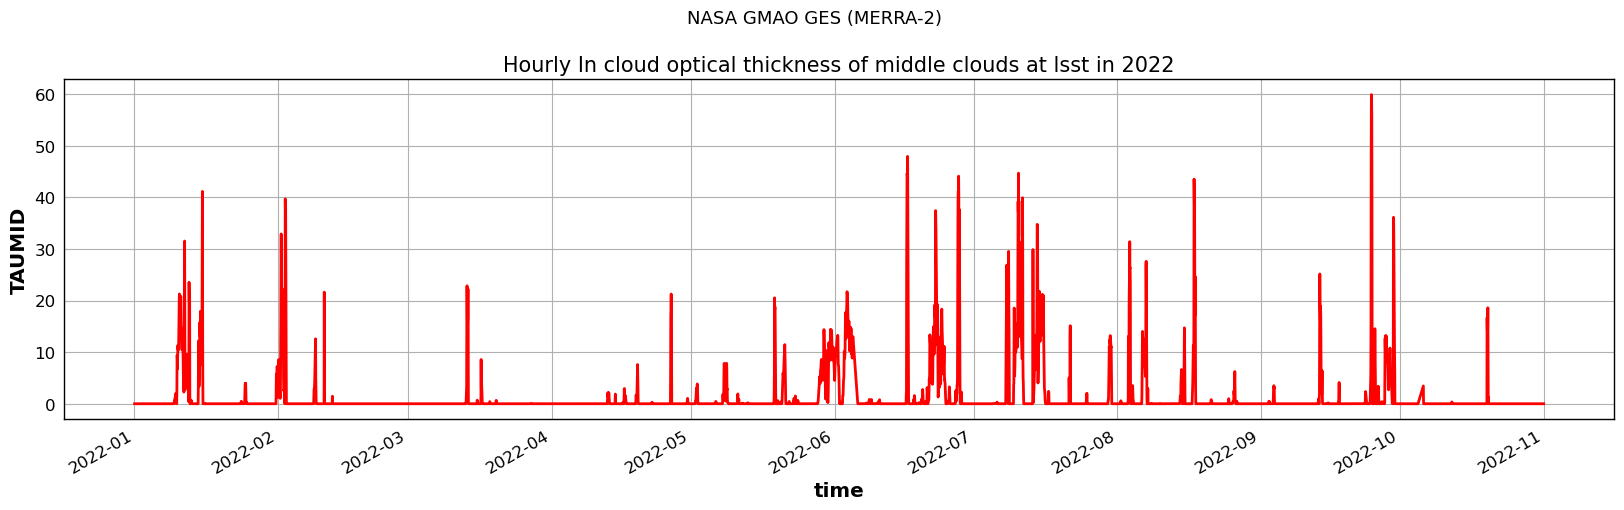

In [38]:
PlotTimeSeries(2,figfile_rad_taumid)

## 4.4) $\tau$- total- clouds

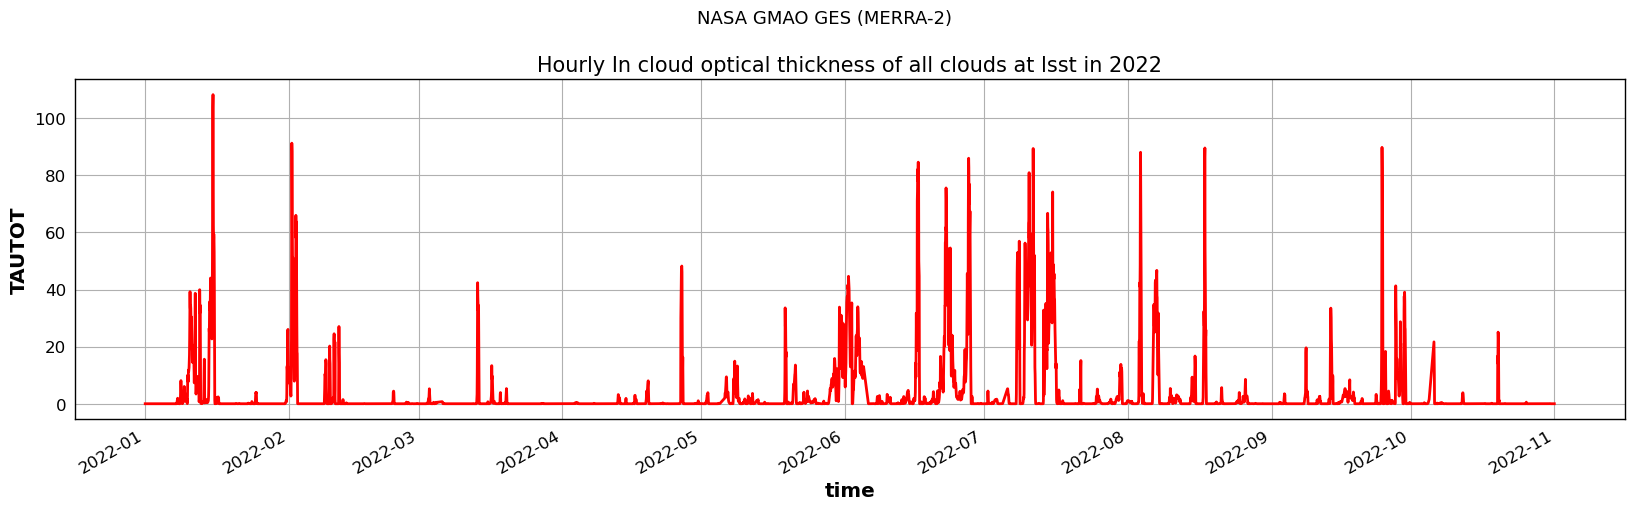

In [39]:
PlotTimeSeries(3,figfile_rad_tautot)

## 5) Output

In [40]:
df_tavg1_2d_rad_Nx.index.name='time'
df_tavg1_2d_rad_Nx.describe()

,TAUHGH,TAULOW,TAUMID,TAUTOT
count,7056.000000,7056.000000,7056.000000,7056.000000
mean,0.488491,1.488109,1.410743,3.387347
std,2.113806,6.038832,4.912659,10.561958
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.030479,0.000000,0.000000,0.605957
max,41.625000,61.828125,59.906250,108.281250


## 5)  Save dataset  in file pandas (csv)
----------------------------------------

In [41]:
dataset=df_tavg1_2d_rad_Nx

In [42]:
dataset.index.name='time'

In [43]:
dataset.describe()

,TAUHGH,TAULOW,TAUMID,TAUTOT
count,7056.000000,7056.000000,7056.000000,7056.000000
mean,0.488491,1.488109,1.410743,3.387347
std,2.113806,6.038832,4.912659,10.561958
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.030479,0.000000,0.000000,0.605957
max,41.625000,61.828125,59.906250,108.281250


In [44]:
dataset.head()

,TAUHGH,TAULOW,TAUMID,TAUTOT
time,,,,
2022-01-01 00:30:00,0.0,0.0,0.0,0.0
2022-01-01 01:30:00,0.0,0.0,0.0,0.0
2022-01-01 02:30:00,0.0,0.0,0.0,0.0
2022-01-01 03:30:00,0.0,0.0,0.0,0.0
2022-01-01 04:30:00,0.0,0.0,0.0,0.0


In [45]:
dataset.to_csv(pandas_filename)

In [46]:
saved_dataset=pd.read_csv(pandas_filename)

In [47]:
saved_dataset.head()

,time,TAUHGH,TAULOW,TAUMID,TAUTOT
0,2022-01-01 00:30:00,0.0,0.0,0.0,0.0
1,2022-01-01 01:30:00,0.0,0.0,0.0,0.0
2,2022-01-01 02:30:00,0.0,0.0,0.0,0.0
3,2022-01-01 03:30:00,0.0,0.0,0.0,0.0
4,2022-01-01 04:30:00,0.0,0.0,0.0,0.0


## 6) Convert dataset into a table and then save in a fits file
--------------------------------------------------------------------------

In [48]:
table = Table.from_pandas(saved_dataset)

In [49]:
table

time,TAUHGH,TAULOW,TAUMID,TAUTOT
str19,float64,float64,float64,float64
2022-01-01 00:30:00,0.0,0.0,0.0,0.0
2022-01-01 01:30:00,0.0,0.0,0.0,0.0
2022-01-01 02:30:00,0.0,0.0,0.0,0.0
2022-01-01 03:30:00,0.0,0.0,0.0,0.0
2022-01-01 04:30:00,0.0,0.0,0.0,0.0
2022-01-01 05:30:00,0.0,0.0,0.0,0.0
2022-01-01 06:30:00,0.0,0.0,0.0,0.0
2022-01-01 07:30:00,0.0,0.0,0.0,0.0
2022-01-01 08:30:00,0.0,0.0,0.0,0.0


In [50]:
table.write(fits_filename,format='fits',overwrite=True)